# Pneumonia Detection Project - Group 3

<b> Goal </b>: The aim of this project is the application of Convolution Neural Networks to read chest X-rays (CXRs) and detect the presence or absence of pneumonia.


<b> Data used </b>: For the project we have used data of x-ray plates obtained from Guangzhou Women and Children’s Medical Center, Guangzhou and available at Kaggle's website through link https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia or http://dx.doi.org/10.17632/rscbjbr9sj.2

<b> Libraries & Framework </b> We have used PyTorch as a framework for deep learning & other Python-based libraries.

<b> Program Flow: </b>
1. First, we made three baseline models and measured their accuracy, precision,recall, and F1 score.
2. Then, we merged the three baseline models into one ensemble of CNNs
3. After that, we made a complex CNN (our "master model") & measured the same metrics.
4. Next, we tried feature extraction through DenseNet169, a pre-trained CNN, and measured the same performance metrics.
5. To verify whether the model was focusing on the right regions of the CXR or not, we performed Grad-CAM as an explainable AI method.
6. Finally, we combined all the data belonging to the "positive" class and produced clusters to identify further patterns in them.

# Program
## Data Loading & Preprocessing
This preprocessing result is common to all baseline models & all pre-trained model in this program.

We are need to upload a Kaggle API token to be able to access Kaggle datasets.

In [ ]:
!pip -q install kaggle

We tracked the progress on the "Weights & Biases" website.

In [ ]:
!pip -q install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.5 MB/s eta 0:00:00


Grad-CAM was installed to later on visualize the region(s) where model was focusing.

In [ ]:
!pip -q install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 17.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Login to the Weight & Biases account.

In [ ]:
import wandb
# Login to W&B account
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Initialize a new run
wandb.init(project='Pneumonia_group_3', entity='utkrisht14')

wandb: Currently logged in as: utkrisht14. Use `wandb login --relogin` to force relogin


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"utkrishtmallick","key":"8238ab76426f30391b1ed55fc2ad45ab"}'}

These commands create a hidden directory for the Kaggle API credentials, copy the API key file there, and set restrictive permissions for it.

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Downloading the Pneumonia dataset from Kaggle.

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:07<00:00, 329MB/s]
100% 2.29G/2.29G [00:07<00:00, 308MB/s]


Importing the necessary libraries.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import re
import time
import random
import shutil
import cv2
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.io as sio
import copy

from os.path import dirname, join as pjoin
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from scipy.sparse import csr_matrix
from sklearn.semi_supervised import LabelPropagation
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc

from PIL import Image
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

Extracting the zip file of the dataset.

In [ ]:
zip_file_path = "/content/chest-xray-pneumonia.zip"

# Path where to extract
extract_to_path = '/content/pneumonia_xrays'

# Open and extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)
    zip_ref.close()

We will train our model on GPU to make it faster. A100 model GPU provided by Google Colab is used for training purposes.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Here we define hyperparameters for later use in this section

In [ ]:
# Hyperparameters
batch_size = 8

Performing the necessary data transformations. We are not performing advanced data augmenattion like RandomRotation() as it is not needed for this kind of medical imaging data. However, we are resizing the images to 256*256.

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    # transforms.CenterCrop(256),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    # transforms.CenterCrop(256),
    transforms.ToTensor(),
])

Defining the training and test set data.

In [ ]:
train_data = datasets.ImageFolder("/content/pneumonia_xrays/chest_xray/train",transform=train_transform)
test_data = datasets.ImageFolder("/content/pneumonia_xrays/chest_xray/test",transform=test_transform)

Converting data into batches format.

In [ ]:
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=False)

Let's see a first batch of images.

Label: tensor([1, 1, 1, 1, 1, 1, 1, 1])


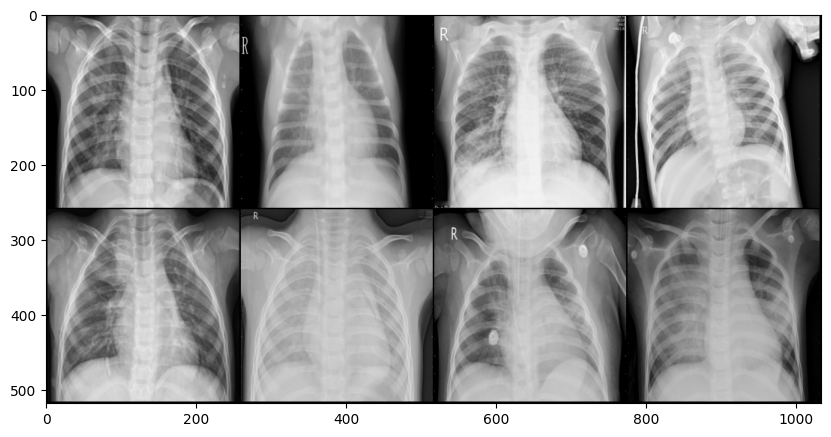

In [ ]:
# Displaying a batch of image (first 8 images since batch_size=8)
for image,label in train_loader:
  break

print(f"Label: {label}")

im = make_grid(image,nrow=4)

plt.figure(figsize=(10,8))
plt.imshow(np.transpose(im.numpy(),(1,2,0)));

## Baseline Models

### Baseline Model-1
In baseline model-1 we have gone with the following architecture:
<table>
<tr> <td> convolution layer_1 </td> </tr>
<tr> <td> avg_pool_1 </td> </tr>
<tr> <td> batch normalization_1 </td> </tr>
<tr> <td> convolution_layer_2 </td> </tr>
<tr> <td> avg_pool_2 </td> </tr>
<tr> <td> batch normalization_2 </td> </tr>
<tr> <td> dropout </td> </tr>
<tr> <td> two fully connected linear layers </td> </tr>
<tr> <td> Output </td> </tr>
</table>

In [ ]:
class BaselineModel_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, stride=1),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Dropout(0.4)

            )

        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 62 * 62, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, 2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1) # Flattening
        x = self.fc_layers(x)
        return x


In [ ]:
# Creating an instance of the model and moving it to computing device
model_1 = BaselineModel_1().to(device)
model_1

BaselineModel_1(
  (conv_layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.4, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=123008, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=2, bias=True)
  )
)

In [ ]:
# Total parameters in our model
sum([p.numel() for p in model_1.parameters()])

14774054

In [ ]:
# Defining the loss function and the optimizer
criterion_base1 = nn.CrossEntropyLoss()
optimizer_base1 = torch.optim.Adam(model_1.parameters(), lr=0.0001)

Next we will make a function to plot our result.

In [ ]:
def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, device, epochs=10):
    '''
    This function trains a PyTorch model on a training dataset, evaluates it on
    a test dataset, records and plots the training and test losses, and then it
    calculates test accuracy for a number of epochs. It logs the progress
    using Weights & Biases ("wandb") and returns the training and test losses
    and accuracies.
    '''
    start_time = time.time()

    train_losses = []
    test_losses = []
    test_correct = []

    for epoch in range(epochs):
        model.train()
        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()

        train_losses.append(loss.item())
        print(f"Loss at the end of epoch {epoch + 1} / {epochs}: {loss.item()} ")

        model.eval()
        correct = 0
        test_loss = 0
        with torch.no_grad():
            for X_test, y_test in test_loader:
                X_test, y_test = X_test.to(device), y_test.to(device)
                y_val = model(X_test)
                test_loss_batch = criterion(y_val, y_test)
                test_loss += test_loss_batch.item()

                predicted = torch.max(y_val, axis=1)[1]
                correct += (predicted == y_test).sum()

        test_losses.append(test_loss)
        test_correct.append(correct)

        wandb.log({"epoch": epoch, "loss": loss.item()})

        print(f"Test loss: {test_loss / len(test_loader):.4f} \t Accuracy: {correct.item()*100 / len(test_loader.dataset):.2f}% \n")

    end_time = time.time()
    print(f"Total time taken is {end_time - start_time} seconds \n")

    # Log training progress (e.g., loss) using Weights & Biases
    wandb.log({"epoch": epoch, "loss": loss.item()})

    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Training Loss')
    plt.title("Training Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(test_losses, label='Validation Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    return train_losses, test_losses, test_correct

Loss at the end of epoch 1 / 5: 0.001959360670298338 
Test loss: 0.6389 	 Accuracy: 80.61% 

Loss at the end of epoch 2 / 5: 0.0001345991768175736 
Test loss: 1.6480 	 Accuracy: 72.44% 

Loss at the end of epoch 3 / 5: 0.016064666211605072 
Test loss: 1.6856 	 Accuracy: 70.83% 

Loss at the end of epoch 4 / 5: 6.629985000472516e-05 
Test loss: 1.8017 	 Accuracy: 75.00% 

Loss at the end of epoch 5 / 5: 0.0007684362935833633 
Test loss: 1.9816 	 Accuracy: 74.52% 

Total time taken is 451.52755880355835 seconds 



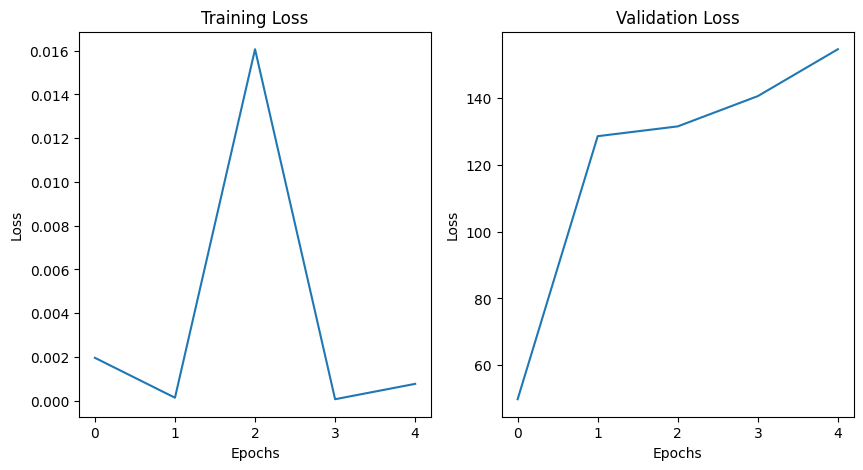

In [ ]:
baseline_1_train = train_and_evaluate(model_1, train_loader, test_loader, optimizer_base1, criterion_base1, device, epochs=5)

Next we will see the performance metrics of our model.

In [ ]:
def result_calc(model, test_loader, device):
    '''
    This function takes a model, the test dataset in minibatches after using DataLoader(),
    a computing device, and calculates 4 key metrics to measure the model's performance:

    (a) Accuracy
    (b) Precision
    (c) Recall
    (d) F1 Score
    '''
    model.eval()
    all_predicted = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculating the metrics
    accuracy = accuracy_score(all_labels, all_predicted)
    precision, recall, fscore, _ = precision_recall_fscore_support(all_labels, all_predicted, average='binary')

    # Printing the metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {fscore:.4f}')

    return accuracy, precision, recall, fscore

In [ ]:
baseline_1_result = result_calc(model_1, test_loader, device="cuda")
baseline_1_result

Accuracy: 0.7452
Precision: 0.7135
Recall: 0.9897
F1 Score: 0.8292


(0.7451923076923077,
 0.7134935304990758,
 0.9897435897435898,
 0.8292158968850698)

### Baseline Model-2
In baseline model-2 we have gone with the following architecture:
<table>
<tr> <td> convolution layer_1 </td> </tr>
<tr> <td> batch normalization_1 </td> </tr>
<tr> <td> max_pool_1 </td> </tr>
<tr> <td> convolution_layer_2 </td> </tr>
<tr> <td> max_pool_2 </td> </tr>
<tr> <td> batch normalization_2 </td> </tr>
<tr> <td> two fully connected linear layers </td> </tr>
<tr> <td> Output </td> </tr>
</table>


In [ ]:
class BaselineModel_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(32 * 64 * 64, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 32 * 64 * 64)  # Flatenning
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model_2 = BaselineModel_2().to(device)
model_2

BaselineModel_2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=131072, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [ ]:
# Calculating class weights for the "weights" parameter of nn.CrossEntropyLoss()
normal_weight = len(train_data) / (2 * train_data.targets.count(0))
pneumonia_weight = len(train_data) / (2 * train_data.targets.count(1))

class_weights = torch.tensor([normal_weight, pneumonia_weight], dtype=torch.float32).to(device)


# Defining the loss function (using class weights) and the optimizer
criterion_base2 = nn.CrossEntropyLoss(weight=class_weights)
optimizer_base2 = torch.optim.Adam(model_2.parameters(), lr=0.0001)

Loss at the end of epoch 1 / 5: 0.4560999572277069 
Test loss: 0.7485 	 Accuracy: 74.36% 

Loss at the end of epoch 2 / 5: 0.0032734835986047983 
Test loss: 0.5520 	 Accuracy: 81.73% 

Loss at the end of epoch 3 / 5: 0.015452725812792778 
Test loss: 0.5448 	 Accuracy: 81.89% 

Loss at the end of epoch 4 / 5: 0.0019259831169620156 
Test loss: 0.8763 	 Accuracy: 77.24% 

Loss at the end of epoch 5 / 5: 0.015300620347261429 
Test loss: 1.0095 	 Accuracy: 75.48% 

Total time taken is 446.9002203941345 seconds 



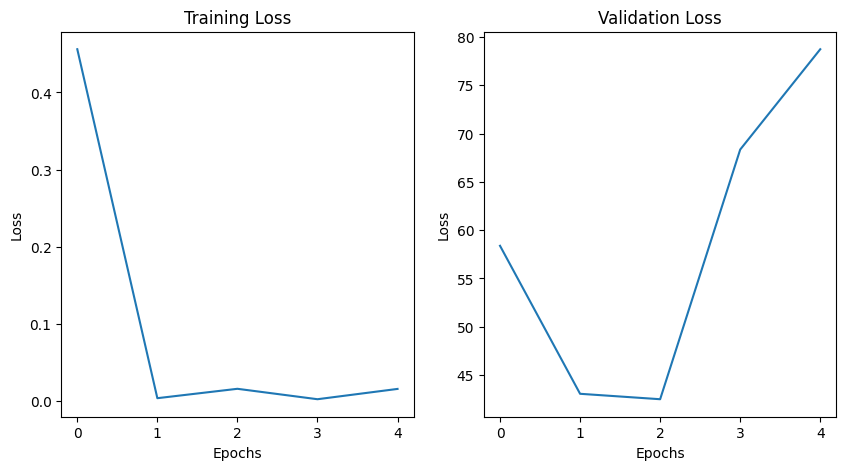

In [ ]:
baseline_2_train = train_and_evaluate(model_2, train_loader, test_loader, optimizer_base2, criterion_base2, device, epochs=5)

In [ ]:
baseline_2_result = result_calc(model_2, test_loader, device="cuda")
baseline_2_result

Accuracy: 0.7548
Precision: 0.7199
Recall: 0.9949
F1 Score: 0.8353


(0.7548076923076923,
 0.7198515769944341,
 0.9948717948717949,
 0.8353067814854682)

### Baseline Model-3
In baseline model-3 we have gone with the following architecture:
<table>
<tr> <td> convolution layer_1 </td> </tr>
<tr> <td> max_pool_1 </td> </tr>
<tr> <td> convolution_layer_2 </td> </tr>
<tr> <td> max_pool_2 </td> </tr>
<tr> <td> convolution_layer_3 </td> </tr>
<tr> <td> max_pool_3 </td> </tr>
<tr> <td> two fully connected linear layers </td> </tr>
<tr> <td> Output </td> </tr>
<table>


In [ ]:
class BaselineModel_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128*32*32, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 2)
        )

    def forward(self,x):
        x = self.conv_layers(x)
        x = x.view(-1, 128*32*32)
        x = self.fc_layers(x)
        return x


In [ ]:
model_3 = BaselineModel_3().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

In [ ]:
# train() and test() functions
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model_3.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model_3(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model_3.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model_3(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


# The actual training by epochs
for t in range(5):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model_3, loss_fn, optimizer)
    test(test_loader, model_3, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.695219  [    8/ 5216]
loss: 0.393893  [  808/ 5216]
loss: 0.209228  [ 1608/ 5216]
loss: 0.446630  [ 2408/ 5216]
loss: 0.026364  [ 3208/ 5216]
loss: 0.135657  [ 4008/ 5216]
loss: 0.020083  [ 4808/ 5216]
Test Error: 
 Accuracy: 71.3%, Avg loss: 1.191097 

Epoch 2
-------------------------------
loss: 0.010086  [    8/ 5216]
loss: 0.097187  [  808/ 5216]
loss: 0.063563  [ 1608/ 5216]
loss: 0.016296  [ 2408/ 5216]
loss: 0.047779  [ 3208/ 5216]
loss: 0.130430  [ 4008/ 5216]
loss: 0.064455  [ 4808/ 5216]
Test Error: 
 Accuracy: 69.7%, Avg loss: 1.004881 

Epoch 3
-------------------------------
loss: 0.497944  [    8/ 5216]
loss: 0.024768  [  808/ 5216]
loss: 0.041338  [ 1608/ 5216]
loss: 0.156980  [ 2408/ 5216]
loss: 0.002240  [ 3208/ 5216]
loss: 0.004086  [ 4008/ 5216]
loss: 0.000591  [ 4808/ 5216]
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.753935 

Epoch 4
-------------------------------
loss: 0.000080  [    8/ 5216]
loss: 0.012630  [  808/ 

In [ ]:
baseline_3_result = result_calc(model_3, test_loader, device="cuda")
baseline_3_result

Accuracy: 0.7628
Precision: 0.7292
Recall: 0.9872
F1 Score: 0.8388


(0.7628205128205128,
 0.7291666666666666,
 0.9871794871794872,
 0.8387799564270153)

### Baseline Models Comparison

In [ ]:
baseline_comparison = pd.DataFrame({"Model_1" : [baseline_1_result[0],baseline_1_result[1],baseline_1_result[2],baseline_1_result[3]],
              "Model_2" : [baseline_2_result[0],baseline_2_result[1],baseline_2_result[2],baseline_2_result[3]],
              "Model_3":  [baseline_3_result[0],baseline_3_result[1],baseline_3_result[2],baseline_3_result[3]]},
                                   index=["Accuracy","Precision","Recall","F1-Score"]).T

baseline_comparison.head()

,Accuracy,Precision,Recall,F1-Score
Model_1,0.745192,0.713494,0.989744,0.829216
Model_2,0.754808,0.719852,0.994872,0.835307
Model_3,0.762821,0.729167,0.987179,0.838780


## Ensemble Model

We made a Ensemble Model which is taking average of the predictions and calculating the result.

In [ ]:
class EnsembleModel(nn.Module):
    def __init__(self, model_1, model_2, model_3, aggregate_predictions):
        super(EnsembleModel, self).__init__()
        self.model_1 = model_1
        self.model_2 = model_2
        self.model_3 = model_3
        self.aggregate_predictions = aggregate_predictions

    def forward(self, x):
        preds1 = self.model_1(x)
        preds2 = self.model_2(x)
        preds3 = self.model_3(x)
        return self.aggregate_predictions([preds1, preds2, preds3])

# Defining an aggregation function
def aggregate_predictions(predictions):
    return torch.mean(torch.stack(predictions), dim=0)

# Instantiating the ensemble model
ensemble_model = EnsembleModel(model_1, model_2, model_3, aggregate_predictions)

# Setting the model to evaluation mode
ensemble_model.eval()

# Iterating over the DataLoader
for inputs, _ in test_loader:
    inputs = inputs.to(device)
    with torch.no_grad():
        predictions = ensemble_model(inputs)

In [ ]:
model_4 = EnsembleModel(model_1,model_2,model_3,aggregate_predictions).to(device)
model_4

EnsembleModel(
  (model_1): BaselineModel_1(
    (conv_layers): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
      (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (2): ReLU(inplace=True)
      (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1))
      (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (6): ReLU(inplace=True)
      (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Dropout(p=0.4, inplace=False)
    )
    (fc_layers): Sequential(
      (0): Linear(in_features=123008, out_features=120, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=120, out_features=84, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=84, out_features=2, bias=True)
    )
  )
  (model_2): BaselineModel_2(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (

In [ ]:
# Defining the loss function and the optimizer
criterion_ensemble = nn.CrossEntropyLoss()
optimizer_ensemble = torch.optim.Adam(model_1.parameters(),lr=1e-4)

Loss at the end of epoch 1 / 5: 0.012334240600466728 
Test loss: 1.8379 	 Accuracy: 73.40% 

Loss at the end of epoch 2 / 5: 0.00030028546461835504 
Test loss: 1.2725 	 Accuracy: 79.33% 

Loss at the end of epoch 3 / 5: 0.00015215124585665762 
Test loss: 2.1638 	 Accuracy: 74.84% 

Loss at the end of epoch 4 / 5: 6.407493629012606e-07 
Test loss: 2.5146 	 Accuracy: 74.36% 

Loss at the end of epoch 5 / 5: 3.2037271466833772e-06 
Test loss: 2.5004 	 Accuracy: 75.00% 

Total time taken is 460.5543167591095 seconds 



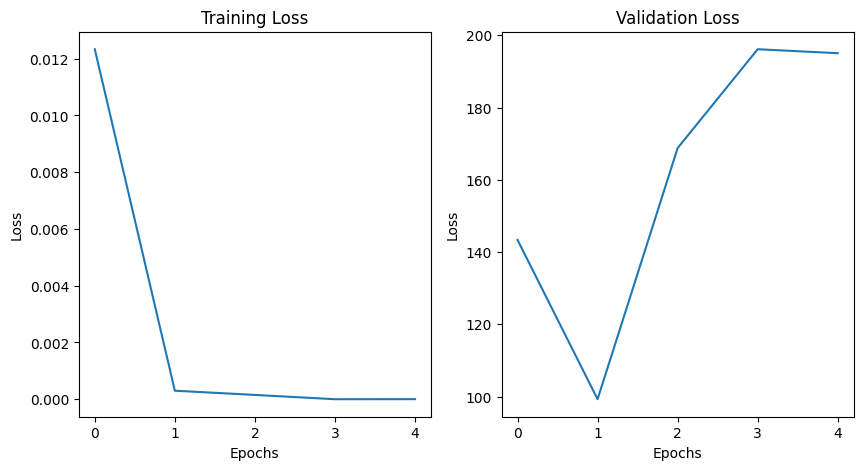

([0.012334240600466728,
  0.00030028546461835504,
  0.00015215124585665762,
  6.407493629012606e-07,
  3.2037271466833772e-06],
 [143.35733071787914,
  99.25372041233564,
  168.77869912779266,
  196.13495911640985,
  195.0316599425923],
 [tensor(458, device='cuda:0'),
  tensor(495, device='cuda:0'),
  tensor(467, device='cuda:0'),
  tensor(464, device='cuda:0'),
  tensor(468, device='cuda:0')])

In [ ]:
ensemble_model = train_and_evaluate(model_4, train_loader, test_loader, optimizer_ensemble, criterion_ensemble, device, epochs=5)
ensemble_model

In [ ]:
ensemble_1_result = result_calc(model_4, test_loader, device="cuda")
ensemble_1_result

Accuracy: 0.7484
Precision: 0.7138
Recall: 0.9974
F1 Score: 0.8321


(0.7483974358974359,
 0.7137614678899082,
 0.9974358974358974,
 0.8320855614973263)

In [ ]:
baseline_comparison.loc["Ensemble_Base_Model"] = [ensemble_1_result[0],ensemble_1_result[1],ensemble_1_result[2],ensemble_1_result[3]]
baseline_comparison

,Accuracy,Precision,Recall,F1-Score
Model_1,0.733974,0.702166,0.997436,0.824153
Model_2,0.775641,0.739464,0.989744,0.846491
Model_3,0.695513,0.673010,0.997436,0.803719
Ensemble_Base_Model,0.748397,0.713761,0.997436,0.832086


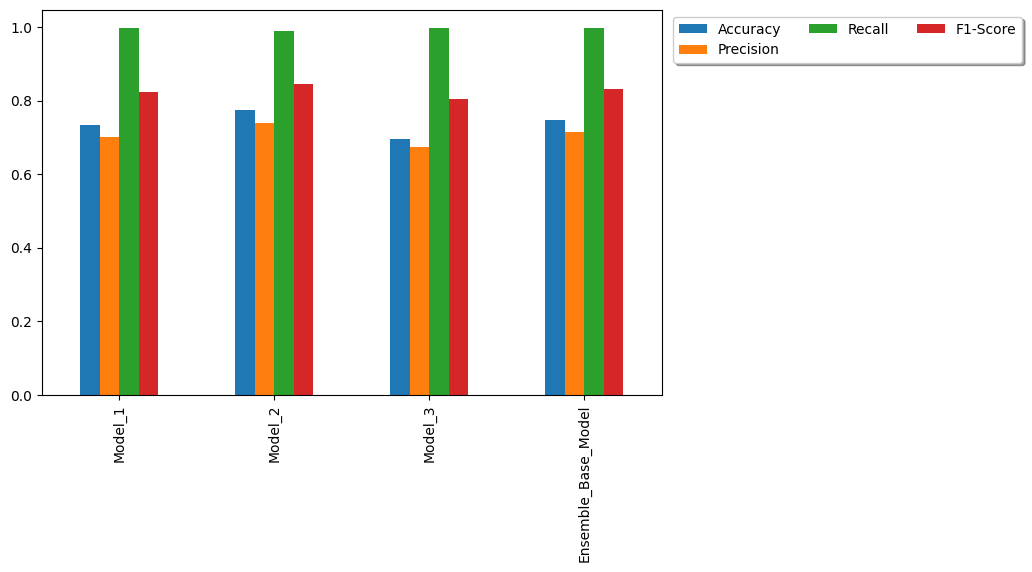

In [ ]:
ax = baseline_comparison.plot(kind="bar",figsize=(8, 5))
ax.legend(loc='upper center', bbox_to_anchor=(1.3,1.0), shadow=True, ncol=3)

## Master Model

Next we will improve the baseline with a new model with increased complexity.

### Pre-processing our images.
First we will pre-process our images data by using contrast-limited adaptive histogram equalization (CLAHE). The motivation for its use can be found in the technical report. Also, here we reduce the images size even further from 256x256 to 224x224.

In [ ]:
# Performing CLAHE on images
def clahe_hist_equalize(folder_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    list_file = os.listdir(folder_path)
    for i in list_file:
        img = cv2.imread(os.path.join(folder_path, i))
        if img is not None:  # Check if the image is loaded correctly
            hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            h, s, v = hsv_img[:, :, 0], hsv_img[:, :, 1], hsv_img[:, :, 2]
            clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=(8, 8))
            v = clahe.apply(v)
            hsv_img = np.dstack((h, s, v))
            eq_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
            output_file_path = os.path.join(output_folder, i)  # Include file name and extension
            mpimg.imsave(output_file_path, eq_img)
        else:
            print(f"Failed to load image: {i}")

Extracting the files preprocessed with CLAHE and saving them

In [ ]:
train_m_normal = clahe_hist_equalize(r"/content/pneumonia_xrays/chest_xray/train/NORMAL",r"modified_images/train_m/NORMAL/")
train_m_pneumonia = clahe_hist_equalize(r"/content/pneumonia_xrays/chest_xray/train/PNEUMONIA",r"modified_images/train_m/PNEUMONIA/")

test_m_normal = clahe_hist_equalize(r"/content/pneumonia_xrays/chest_xray/test/NORMAL",r"modified_images/test_m/NORMAL/")
test_m_pneumonia = clahe_hist_equalize(r"/content/pneumonia_xrays/chest_xray/test/PNEUMONIA",r"modified_images/test_m/PNEUMONIA/")

val_m_normal = clahe_hist_equalize(r"/content/pneumonia_xrays/chest_xray/val/NORMAL",r"modified_images/val_m/NORMAL/")
val_m_pneumonia = clahe_hist_equalize(r"/content/pneumonia_xrays/chest_xray/val/NORMAL",r"modified_images/val_m/PNEUMONIA/")

Performing other necessary preprocessing step.  

In [ ]:
train_transform_clahe = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.CenterCrop(224),
    transforms.ToTensor()
])

test_transform_clahe = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
])

In [ ]:
train_data_clahe = datasets.ImageFolder(r"modified_images/train_m", transform=train_transform_clahe)
test_data_clahe = datasets.ImageFolder(r"modified_images/test_m", transform=test_transform_clahe)

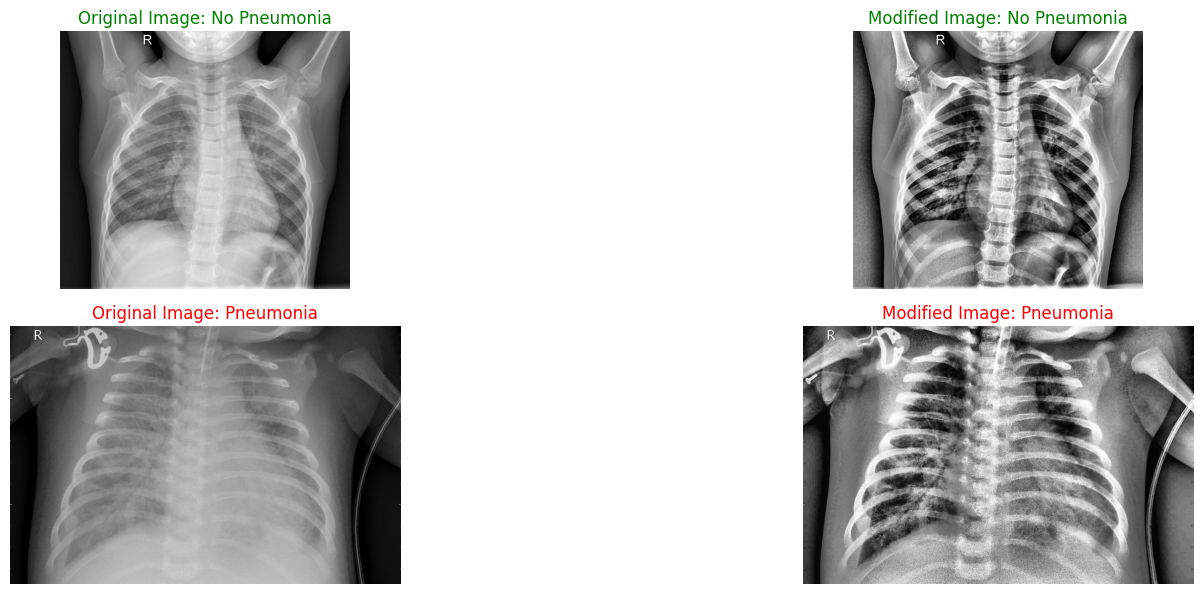

In [ ]:
# Let's display the images by comparing them to their original versions side by side.
plt.figure(figsize=(16,9))

plt.subplot(3,2,1)
img_1 = mpimg.imread(r"/content/pneumonia_xrays/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
plt.imshow(img_1,cmap="gray")
plt.title("Original Image: No Pneumonia",color="green")
plt.axis("off")

plt.subplot(3,2,2)
img_2 = mpimg.imread(r"/content/modified_images/train_m/NORMAL/IM-0115-0001.jpeg")
plt.imshow(img_2)
plt.title("Modified Image: No Pneumonia",color="green")
plt.axis("off")

plt.subplot(3,2,3)
img_1 = mpimg.imread(r"/content/pneumonia_xrays/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg")
plt.imshow(img_1,cmap="gray")
plt.title("Original Image: Pneumonia",color="red")
plt.axis("off")

plt.subplot(3,2,4)
img_2 = mpimg.imread(r"/content/modified_images/train_m/PNEUMONIA/person1000_bacteria_2931.jpeg")
plt.imshow(img_2)
plt.title("Modified Image: Pneumonia",color="red")
plt.axis("off")
plt.tight_layout()
plt.show();

### Building the Master Model

In [ ]:
# Defining our Master Model
class MasterModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),
            nn.Dropout(0.25),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(512),
            nn.Dropout(0.25)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(512*5*5, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes)
        )

    def forward(self,x):
        x = self.conv_layers(x)
        x = x.view(-1, 512*5*5)
        x = self.fc_layers(x)
        return x

### Hyperparameters for Training K-Fold CV


In [ ]:
# Hyperparameters
batch_size = 64
num_classes = 2
learning_rate = 0.001
num_epochs = 5
num_folds = 5

In [ ]:
# Initializing StratifiedKFold() since we have an imbalanced dataset
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=30)

# Initializing lists to store evaluation metrics
all_accuracies = []
all_sensitivities = []
all_recalls = []
all_f1_scores = []
all_confusion_matrices = []
all_roc_curves = []

# Calculating class weights based on inverse class frequency method
normal_weight = len(train_data_clahe) / (2 * train_data_clahe.targets.count(0))
pneumonia_weight = len(train_data_clahe) / (2 * train_data_clahe.targets.count(1))

class_weights = torch.tensor([normal_weight, pneumonia_weight], dtype=torch.float32).to(device)

### Model initilaization, loss & optimizers

In [ ]:
# Instantiating the model
model_master = MasterModel().to(device)

In [ ]:
# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = torch.optim.Adam(model_master.parameters(), lr=0.001)

Next we will train the model using 5-fold stratified cross vaildation.

Test results 
 ----------------------
Fold 1 - Accuracy: 0.9473, Sensitivity: 0.9337, Recall: 1.0000, F1 Score: 0.9657
Confusion Matrix:
[[214  55]
 [  0 775]]
ROC AUC: 0.9973
Test results 
 ----------------------
Fold 2 - Accuracy: 0.9108, Sensitivity: 0.8938, Recall: 0.9987, F1 Score: 0.9433
Confusion Matrix:
[[176  92]
 [  1 774]]
ROC AUC: 0.9876
Test results 
 ----------------------
Fold 3 - Accuracy: 0.9578, Sensitivity: 0.9474, Recall: 0.9987, F1 Score: 0.9724
Confusion Matrix:
[[225  43]
 [  1 774]]
ROC AUC: 0.9991
Test results 
 ----------------------
Fold 4 - Accuracy: 0.9933, Sensitivity: 0.9987, Recall: 0.9923, F1 Score: 0.9955
Confusion Matrix:
[[267   1]
 [  6 769]]
ROC AUC: 0.9999
Test results 
 ----------------------
Fold 5 - Accuracy: 0.9243, Sensitivity: 1.0000, Recall: 0.8981, F1 Score: 0.9463
Confusion Matrix:
[[268   0]
 [ 79 696]]
ROC AUC: 1.0000

Average Metrics Across Folds:
Accuracy: 0.9467
Sensitivity: 0.9547
Recall: 0.9775
F1 Score: 0.9646


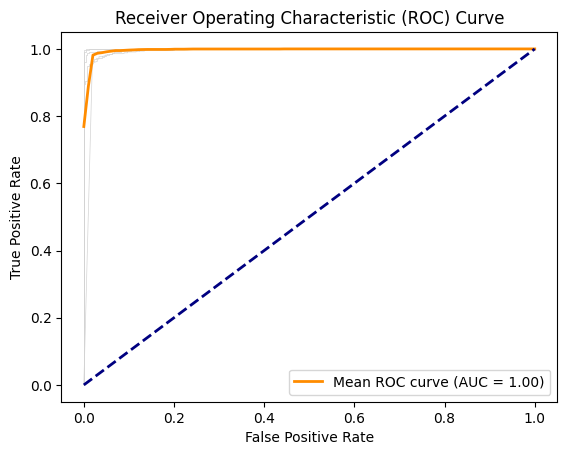

In [ ]:
# Performing cross-validation
for fold, (train_index, test_index) in enumerate(skf.split(X=np.zeros(len(train_data_clahe)), y=train_data_clahe.targets)):

    # Splitting the dataset into train and test sets for the current fold
    train_set = torch.utils.data.Subset(train_data_clahe, train_index)
    test_set = torch.utils.data.Subset(train_data_clahe, test_index)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle = True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    # Training the model
    for epoch in range(num_epochs):
        model_master.train()
        train_loss = 0
        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            y_pred = model_master(X_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        # Saving the logs to Weight & Biases
        wandb.log({"Train Loss": train_loss / len(train_loader), "Epoch": epoch})

    # Evaluating the model on the test set
    model_master.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_val = model_master(X_test)
            _, predicted = torch.max(y_val, 1)
            y_true.extend(y_test.cpu().numpy())
            y_scores.extend(torch.softmax(y_val, dim=1)[:, 1].cpu().numpy())

    # Calculating the evaluation metrics
    accuracy = accuracy_score(y_true, np.round(y_scores))
    sensitivities = precision_recall_fscore_support(y_true, np.round(y_scores), pos_label=1, average='binary')[0]
    recalls = precision_recall_fscore_support(y_true, np.round(y_scores), pos_label=1, average='binary')[1]
    f1_scores = precision_recall_fscore_support(y_true, np.round(y_scores), pos_label=1, average='binary')[2]
    confusion_matrix_arr = confusion_matrix(y_true, np.round(y_scores))
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Printing or storing the metrics for the current fold
    print("Test results \n ----------------------")
    print(f"Fold {fold + 1} - Accuracy: {accuracy:.4f}, Sensitivity: {sensitivities:.4f}, Recall: {recalls:.4f}, F1 Score: {f1_scores:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix_arr)
    print(f"ROC AUC: {roc_auc:.4f}")

    # Storing the metrics in lists for later analysis
    all_accuracies.append(accuracy)
    all_sensitivities.append(sensitivities)
    all_recalls.append(recalls)
    all_f1_scores.append(f1_scores)
    all_confusion_matrices.append(confusion_matrix_arr)
    all_roc_curves.append((fpr, tpr, roc_auc))

# Printing the average metrics across all folds
print("\nAverage Metrics Across Folds:")
print(f"Accuracy: {np.mean(all_accuracies):.4f}")
print(f"Sensitivity: {np.mean(all_sensitivities):.4f}")
print(f"Recall: {np.mean(all_recalls):.4f}")
print(f"F1 Score: {np.mean(all_f1_scores):.4f}")

# Plotting the average ROC curve across folds
plt.figure()
for fpr, tpr, _ in all_roc_curves:
    plt.plot(fpr, tpr, color='lightgray', lw=0.5)

mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr, _ in all_roc_curves], axis=0)
plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=2, label=f'Mean ROC curve (AUC = {np.mean([roc_auc for _, _, roc_auc in all_roc_curves]):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Checking model on real-world unseen data



Let's try to use the model for inference on an external file it has never seen.

For this, we will upload this external image with pneumonia and check our model's performance on it

In [ ]:
file_to_check = files.upload()

Saving chest_external.jpg to chest_external.jpg


In [ ]:
# Saving the master model's parameters
torch.save(model_master.state_dict(), 'model_master.pth')

In [ ]:
def predict_image_class(image_path, transform, model, device, class_names):

    # Loading and display the image
    image = Image.open(image_path).convert("RGB")

    # Applying the transformation
    transformed_image = transform(image)

    # Adding batch dimension
    image_batch = transformed_image.unsqueeze(0).to(device)

    # Setting the model to evaluation mode and make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(image_batch)
        probabilities = F.softmax(outputs, dim=1)
        prob, _ = torch.max(probabilities, axis=1)

    # Getting the predicted class
    predicted_class = torch.max(outputs, 1)[1]
    predicted_label = class_names[predicted_class.item()]

    print(f"The image likely belongs to the class: {predicted_label} with probability {prob[0]}")
    plt.imshow(image)

The image likely belongs to the class: PNEUMONIA with probability 0.9999998807907104


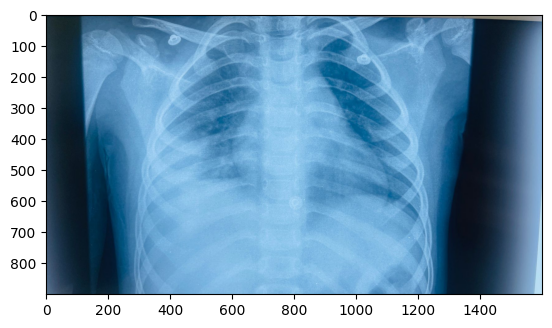

In [ ]:
predict_image_class("/content/chest_external.jpg", transform=test_transform_clahe, model=model_master, device="cuda",
                    class_names=test_data_clahe.classes)

From this, it looks like that our model is performing really good.

## Pre-trained Model (Feature extraction with DenseNet169)

In [ ]:
# Loading DenseNet model with pre-trained weights from ImageNet
model_densenet = models.densenet169(weights="IMAGENET1K_V1")

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 86.4MB/s]


In [ ]:
# Performing feature extraction
for param in model_densenet.parameters():
     param.requires_grad = False

# Adjusting the output size (changing just the output layer, the rest
# remain frozen)
num_features = model_densenet.classifier.in_features
model_densenet.classifier = nn.Linear(num_features, 2)

# Defining the model
model_densenet = model_densenet.to(device)

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_densenet.parameters(), lr=learning_rate)

Next we will deal with stratified K-Fold.

In [ ]:
# Instance of StratifiedKFold() for "num_folds"-fold stratified CV to
# handle class imbalances
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=30)

# Initializing lists to store evaluation metrics
all_accuracies = []
all_sensitivities = []
all_recalls = []
all_f1_scores = []
all_confusion_matrices = []
all_roc_curves = []

### Training the model

Test results 
 ----------------------
Fold 1 - Accuracy: 0.9646, Sensitivity: 0.9601, Recall: 0.9935, F1 Score: 0.9765
Confusion Matrix:
[[237  32]
 [  5 770]]
ROC AUC: 0.9943
Test results 
 ----------------------
Fold 2 - Accuracy: 0.9578, Sensitivity: 0.9668, Recall: 0.9768, F1 Score: 0.9718
Confusion Matrix:
[[242  26]
 [ 18 757]]
ROC AUC: 0.9923
Test results 
 ----------------------
Fold 3 - Accuracy: 0.9597, Sensitivity: 0.9854, Recall: 0.9600, F1 Score: 0.9725
Confusion Matrix:
[[257  11]
 [ 31 744]]
ROC AUC: 0.9928
Test results 
 ----------------------
Fold 4 - Accuracy: 0.9645, Sensitivity: 0.9881, Recall: 0.9639, F1 Score: 0.9758
Confusion Matrix:
[[259   9]
 [ 28 747]]
ROC AUC: 0.9960
Test results 
 ----------------------
Fold 5 - Accuracy: 0.9847, Sensitivity: 0.9884, Recall: 0.9910, F1 Score: 0.9897
Confusion Matrix:
[[259   9]
 [  7 768]]
ROC AUC: 0.9971

Average Metrics Across Folds:
Accuracy: 0.9663
Sensitivity: 0.9778
Recall: 0.9770
F1 Score: 0.9773


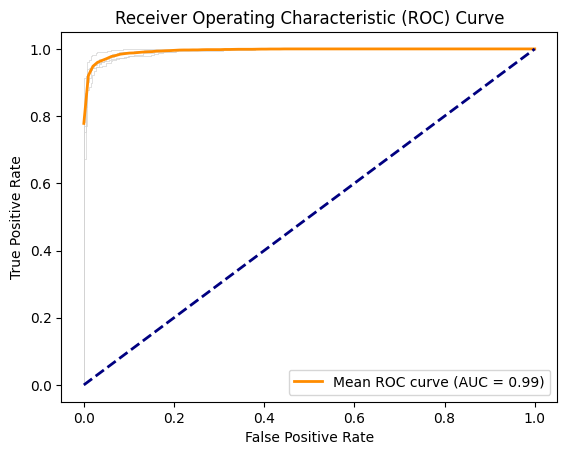

In [ ]:
# Performing cross-validation
for fold, (train_index, test_index) in enumerate(skf.split(X=np.zeros(len(train_data_clahe)), y=train_data_clahe.targets)):

    # Splitting the dataset into train and test sets for the current fold
    train_set_dense = torch.utils.data.Subset(train_data_clahe, train_index)
    test_set_dense = torch.utils.data.Subset(train_data_clahe, test_index)

    train_loader_dense = DataLoader(train_set_dense, batch_size=batch_size, shuffle = True)
    test_loader_dense = DataLoader(test_set_dense, batch_size=batch_size, shuffle=False)

    # Training the model
    for epoch in range(num_epochs):
        model_densenet.train()
        train_loss = 0
        for X_train, y_train in train_loader_dense:
            X_train, y_train = X_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            y_pred = model_densenet(X_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        # Saving the logs to Weight & Biases
        wandb.log({"Train Loss": train_loss / len(train_loader), "Epoch": epoch})

    # Evaluating the model on the test set
    model_densenet.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for X_test, y_test in test_loader_dense:
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_val = model_densenet(X_test)
            _, predicted = torch.max(y_val, 1)
            y_true.extend(y_test.cpu().numpy())
            y_scores.extend(torch.softmax(y_val, dim=1)[:, 1].cpu().numpy())

    # Calculating the evaluation metrics
    accuracy = accuracy_score(y_true, np.round(y_scores))
    sensitivities = precision_recall_fscore_support(y_true, np.round(y_scores), pos_label=1, average='binary')[0]
    recalls = precision_recall_fscore_support(y_true, np.round(y_scores), pos_label=1, average='binary')[1]
    f1_scores = precision_recall_fscore_support(y_true, np.round(y_scores), pos_label=1, average='binary')[2]
    confusion_matrix_arr = confusion_matrix(y_true, np.round(y_scores))
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Printing or storing the metrics for the current fold
    print("Test results \n ----------------------")
    print(f"Fold {fold + 1} - Accuracy: {accuracy:.4f}, Sensitivity: {sensitivities:.4f}, Recall: {recalls:.4f}, F1 Score: {f1_scores:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix_arr)
    print(f"ROC AUC: {roc_auc:.4f}")

    # Storing the metrics in lists for later analysis
    all_accuracies.append(accuracy)
    all_sensitivities.append(sensitivities)
    all_recalls.append(recalls)
    all_f1_scores.append(f1_scores)
    all_confusion_matrices.append(confusion_matrix_arr)
    all_roc_curves.append((fpr, tpr, roc_auc))

# Printing the average metrics across all folds
print("\nAverage Metrics Across Folds:")
print(f"Accuracy: {np.mean(all_accuracies):.4f}")
print(f"Sensitivity: {np.mean(all_sensitivities):.4f}")
print(f"Recall: {np.mean(all_recalls):.4f}")
print(f"F1 Score: {np.mean(all_f1_scores):.4f}")

# Plotting the average ROC curve across folds
plt.figure()
for fpr, tpr, _ in all_roc_curves:
    plt.plot(fpr, tpr, color='lightgray', lw=0.5)

mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr, _ in all_roc_curves], axis=0)
plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=2, label=f'Mean ROC curve (AUC = {np.mean([roc_auc for _, _, roc_auc in all_roc_curves]):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Check the model prediction on unseen data.

Let's check the model on unseen data.

The image likely belongs to the class: NORMAL with probability 0.9797995686531067


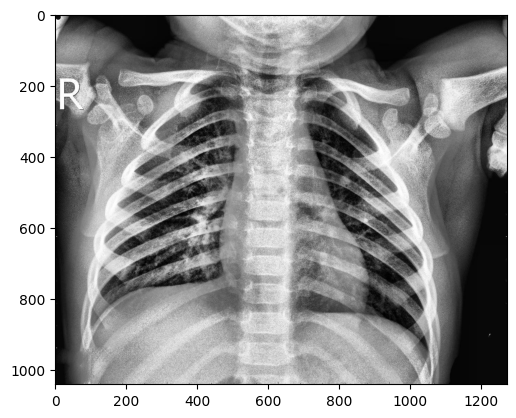

In [ ]:
predict_image_class("/content/modified_images/val_m/NORMAL/NORMAL2-IM-1430-0001.jpeg", transform=test_transform_clahe, model=model_densenet, device="cuda",
                    class_names=test_data_clahe.classes)

From this model performance looks good. We can probably attribute some of this performance to the use of CLAHE as can be seen above.

## Grad-CAM (Gradient-weighted Class Activation Mapping)
Now, we would like to better understand how is our model is performance. As an explainable AI method, we will use Grad-CAM. We will try it on our master model.

In [ ]:
def display_gradcam(model, dataloader, class_idx, target_layers, image_idx=0):
    images, labels = next(iter(dataloader))

    input_image = images[image_idx].unsqueeze(0)
    print("Selected image shape:", input_image.shape)
    input_label = labels[image_idx]

    cam = GradCAM(model=model, target_layers=target_layers)

    targets = [ClassifierOutputTarget(class_idx)]  # Class index for Grad-CAM
    grayscale_cam = cam(input_tensor=input_image, targets=targets)[0, :]

    # Converting to numpy for visualization
    rgb_img = np.transpose(input_image.squeeze().numpy(), (1, 2, 0))
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

    # Creating the visualization
    heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    superimposed_img = heatmap * 0.4 + rgb_img
    superimposed_img = superimposed_img / superimposed_img.max()

    # Displaying the visualizations
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_img)
    plt.axis("off")
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title("Grad-CAM")
    plt.show()


Selected image shape: torch.Size([1, 3, 224, 224])


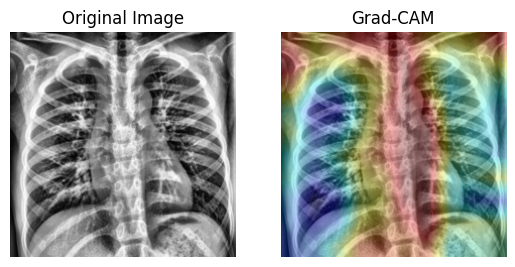

In [ ]:
display_gradcam(model_master, test_loader_clahe, 1, target_layers=[model_master.conv_layers[20]],image_idx=3)

Selected image shape: torch.Size([1, 3, 224, 224])


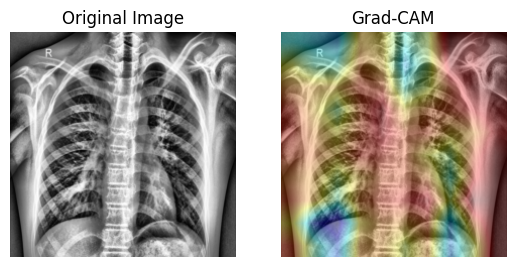

In [ ]:
display_gradcam(model_master, test_loader_clahe, 1, target_layers=[model_master.conv_layers[20]],image_idx=7)

## Clustering of Images
Next, we are going to add clustering of images. But we will only process images which belong to the pneumonia class as there may be some pattern among images, like severity of disease, part exposed or maybe some medical factors like variants. We will follow the technique of Semantic Clustering by Adopting Nearest neighbors (SCAN) method.     

Also we will track now our progress on Weight & Biases.

### Making a single class dataset.

Since our data contains only one label, we need to define the Dataset by ourself.

In [ ]:
class SingleClassDataset:
    def __init__(self, folder_path, transform=None):

        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image, self.image_files[idx]  # Return both the image and filename


Transforming the data for our single labeled dataset.

In [ ]:
transformations = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
    transforms.Resize((224,224)),
    # transforms.CenterCrop(224),
    transforms.ToTensor()
])

### Extracting all the "POSITIVE" (Pneumonia) class files into a single folder.  

Next we want to combine all the pneumonia cases from train, test and validation.

In [ ]:
# Creating a folder that combine all the pneumonia files
source_folders = ['/content/pneumonia_xrays/chest_xray/train/PNEUMONIA', '/content/pneumonia_xrays/chest_xray/test/PNEUMONIA',
                  '/content/pneumonia_xrays/chest_xray/val/PNEUMONIA']
destination_folder = '/content/all_pneumonia_images'

# Creating the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Copying each file from the source folders to the destination folder
for folder in source_folders:
    for filename in os.listdir(folder):
        source_path = os.path.join(folder, filename)
        destination_path = os.path.join(destination_folder, filename)
        shutil.copy2(source_path, destination_path)

In [ ]:
folder_path = '/content/all_pneumonia_images'
dataset = SingleClassDataset(folder_path=folder_path, transform=transformations)

In this step we are checking whether we have extracted all the files or not.

In [ ]:
# Defining the path to the folder
folder_path = '/content/all_pneumonia_images'

# Checking for the total number of files in dataset
num_files = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])

print(f"Total number of images in the folder: {num_files}")

Total number of images in the folder: 4273


In [ ]:
pneumonia_dataloader = DataLoader(dataset,batch_size=1,shuffle=True)

### Making an Autoencoder

Since our data has a single class, it doesn't have a label to compare with. So, we need to define an Autoencoder. And in this case loss, would be `nn.MSELoss()`.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model_auto_enc = Autoencoder().to(device)
model_auto_enc

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): S

### Training the Autoencoder

In [ ]:
# Defining the loss for Autoencoder
criterion_unsup = nn.MSELoss()

num_epochs = 10
for epoch in range(num_epochs):
    for batch in pneumonia_dataloader:
        data = batch[0].to(device)

        # Forward pass
        reconstructed_data = model_auto_enc(data)

        loss = criterion_unsup(reconstructed_data, data)  # Compare reconstructed data to original

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Logging training progress
        wandb.log({"epoch": epoch, "loss": loss.item()})

In [ ]:
torch.save(model_auto_enc.state_dict(), 'autoencoder_state_dict.pth')

In [ ]:
state_dict = torch.load('autoencoder_state_dict.pth')
model_auto_enc.load_state_dict(state_dict)

<All keys matched successfully>

### Making the necesaary pre-processing function

In [ ]:
def extract_features(model, dataloader):
    model.eval()
    features = []

    with torch.no_grad():
        for batch in dataloader:
            data = batch[0].to(device)
            output = model(data)
            # Flatten the output and convert to numpy array
            output_flat = output.view(output.size(0), -1).cpu().detach().numpy()
            features.append(output_flat)

    return np.concatenate(features, axis=0)


In [ ]:
features = extract_features(model_auto_enc,pneumonia_dataloader)

Next task is to perform the nearest neighbour search.  

In [ ]:
def nearest_nbr_search(features,n_nbrs = 5):
  nbrs = NearestNeighbors(n_neighbors=n_nbrs,algorithm="auto").fit(features)
  distances, indices = nbrs.kneighbors(features)
  return indices

We need to create initial labels using K-Means clustering.

In [ ]:
def initialize_labels(features, num_clusters):
    # Performing a preliminary clustering (like K-means) on the features
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(features)
    initial_labels = kmeans.labels_
    return initial_labels

Next we need to create an adjacency matrix based on the nearest neighbors


In [ ]:
initial_labels = initialize_labels(features, num_clusters=3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
def create_adjacency_matrix(neighbors):

    num_points = len(neighbors)
    adjacency_matrix = np.zeros((num_points, num_points), dtype=np.float32)

    for i, neighbor_indices in enumerate(neighbors):
        for neighbor in neighbor_indices:
            adjacency_matrix[i, neighbor] = 5  # Marking as neighbors

    return csr_matrix(adjacency_matrix)  # Converting to a sparse matrix for efficiency

### Performing Semantic Clustering

Now we will define our main function `SCAN` to segment the models.

In [ ]:
def SCAN(model,dataloader,n_nbrs=5):

  # Combining all steps.
  # 1. Feature extraction
  features = extract_features(model,dataloader)
  # 2. Finding nearest neighbours
  neighbors = nearest_nbr_search(features,n_nbrs)
  # 3. Clustering the data points
  adjacency_matrix = create_adjacency_matrix(neighbors)
  label_prop_model = LabelPropagation(kernel='knn', n_neighbors=n_nbrs)
  label_prop_model.fit(features, initial_labels)  # initial_labels from K_means clustering
  clusters = label_prop_model.transduction_
  return clusters

In [ ]:
# Applying SCAN
clusters = SCAN(model_auto_enc, pneumonia_dataloader)

### Extract all the names from the images

In [ ]:
def get_image_names_by_cluster(clusters, dataloader):
    image_names_by_cluster = [[] for _ in range(max(clusters) + 1)]

    # Iterating over dataloader and clusters simultaneously
    for image_data, cluster in zip(dataloader, clusters):
        # Extracting filename; image_data is a tuple (image, filename)
        _, filename = image_data
        # Appending filename to the corresponding cluster list
        image_names_by_cluster[cluster].append(filename)

    return image_names_by_cluster

In [ ]:
image_names_by_cluster = get_image_names_by_cluster(clusters, pneumonia_dataloader)

In [ ]:
len(image_names_by_cluster[0]) + len(image_names_by_cluster[1]) + len(image_names_by_cluster[2])

4273

In [ ]:
cluster_0 = image_names_by_cluster[0]
cluster_1 = image_names_by_cluster[1]
cluster_2 = image_names_by_cluster[2]

In [ ]:
len(cluster_0), len(cluster_1), len(cluster_2)

(1950, 1501, 822)

In [ ]:
# Initializing the counter
counter = 0

# Iterating over each tuple in the list
for item in cluster_0:
    # Each tuple contains one string, so we get that string
    filename = item[0]

    # Checking if 'virus' or 'bacteria' is not in the filename
    if 'virus' not in filename and 'bacteria' not in filename:
        # If neither 'virus' nor 'bacteria' is found, increment the counter
        counter += 1

# Printing the final count
print("Count of files without 'virus' or 'bacteria':", counter)

Count of files without 'virus' or 'bacteria': 0


In [ ]:
# Initializing the counter
counter = 0

# Iterating over each tuple in the list
for item in cluster_1:
    # Each tuple contains one string, so we get that string
    filename = item[0]

    # Check if 'virus' or 'bacteria' is not in the filename
    if 'virus'  in filename and 'bacteria'  in filename:
        # If neither 'virus' nor 'bacteria' is found, increment the counter
        counter += 1

# Print the final count
print("Count of files without 'virus' or 'bacteria':", counter)

Count of files without 'virus' or 'bacteria': 0


In [ ]:
# Initialize the counter
counter_cluster0_bacteria = 0
counter_cluster0_virus = 0

# Iterate over each tuple in the list
for item in cluster_0:
    # Each tuple contains one string, so we get that string
    filename = item[0]

    # Check if 'virus' or 'bacteria' is in the filename
    if 'virus' in filename:
      counter_cluster0_virus += 1
    else:
      counter_cluster0_bacteria += 1


# Print the final count
print("Count of files with 'bacteria' in cluster_0':", counter_cluster0_bacteria)
print("Count of files with 'virus' in cluster_0: ", counter_cluster0_virus)

Count of files with 'bacteria' in cluster_0': 1294
Count of files with 'virus' in cluster_0:  656


In [ ]:
# Initialize the counter
counter_cluster1_bacteria = 0
counter_cluster1_virus = 0

# Iterate over each tuple in the list
for item in cluster_1:
    # Each tuple contains one string, so we get that string
    filename = item[0]

    # Check if 'virus' or 'bacteria' is in the filename
    if 'virus' in filename:
      counter_cluster1_virus += 1
    else:
      counter_cluster1_bacteria += 1


# Print the final count
print("Count of files with 'bacteria' in cluster_1':", counter_cluster1_bacteria)
print("Count of files with 'virus' in cluster_1: ", counter_cluster1_virus)

Count of files with 'bacteria' in cluster_1': 948
Count of files with 'virus' in cluster_1:  553


In [ ]:
# Initialize the counter
counter_cluster2_bacteria = 0
counter_cluster2_virus = 0

# Iterate over each tuple in the list
for item in cluster_2:
    # Each tuple contains one string, so we get that string
    filename = item[0]

    # Check if 'virus' or 'bacteria' is in the filename
    if 'virus' in filename:
      counter_cluster2_virus += 1
    else:
      counter_cluster2_bacteria += 1


# Print the final count
print("Count of files with 'bacteria' in cluster_2':", counter_cluster2_bacteria)
print("Count of files with 'virus' in cluster_2: ", counter_cluster2_virus)

Count of files with 'bacteria' in cluster_2': 538
Count of files with 'virus' in cluster_2:  284


In [ ]:
# Creating the DataFrame
data_cluster = {
    'Cluster': ['Cluster 0', 'Cluster 1','Cluster 2'],
    'Bacteria Count': [counter_cluster0_bacteria, counter_cluster1_bacteria,counter_cluster2_bacteria],
    'Virus Count': [counter_cluster0_virus, counter_cluster1_virus,counter_cluster2_virus]
}

df_cluster = pd.DataFrame(data_cluster)
df_cluster.head()

,Cluster,Bacteria Count,Virus Count
0,Cluster 0,1294,656
1,Cluster 1,948,553
2,Cluster 2,538,284


### Saving and displaying random images from each cluster

In [ ]:
def save_random_images_from_clusters(image_names_by_cluster, source_directory, target_directory, num_images=10):
    # Check if path exists or not
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)

    for cluster_id, image_names in enumerate(image_names_by_cluster):
        # Ensure we don't try to select more images than available
        num_images_to_select = min(num_images, len(image_names))

        # Selecting the images randomly
        selected_images = random.sample(image_names, num_images_to_select)

        # Create a subdirectory for each cluster
        cluster_directory = os.path.join(target_directory, f"cluster_{cluster_id}")
        if not os.path.exists(cluster_directory):
            os.makedirs(cluster_directory)

        # Copy each selected image to the cluster directory
        for image_tuple in selected_images:
            # Extract filename from tuple
            image_name = image_tuple[0]
            source_path = os.path.join(source_directory, image_name)
            target_path = os.path.join(cluster_directory, image_name)
            shutil.copy2(source_path, target_path)

# Executing the function
save_random_images_from_clusters(image_names_by_cluster, '/content/all_pneumonia_images', '/content/clustered_images')


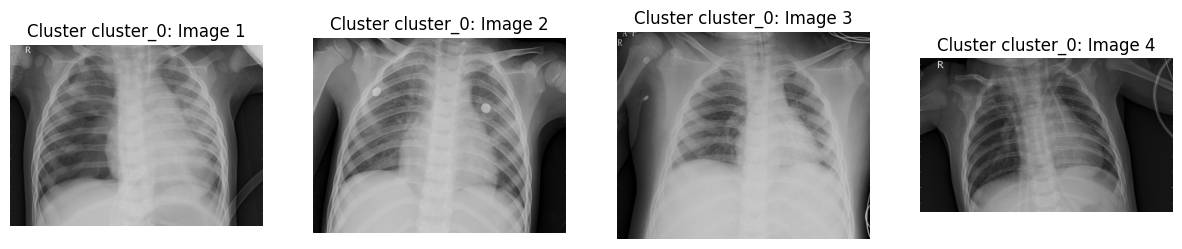

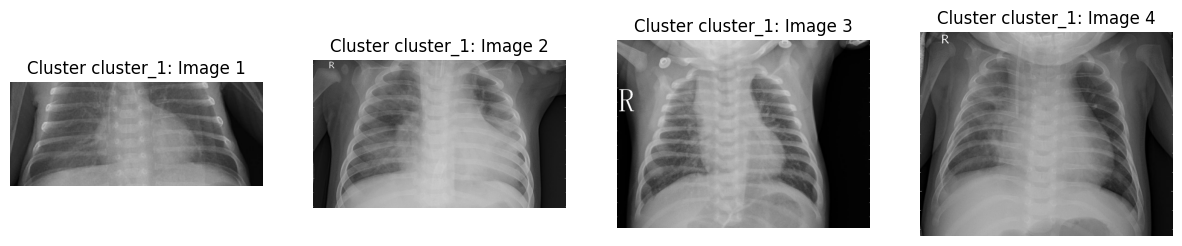

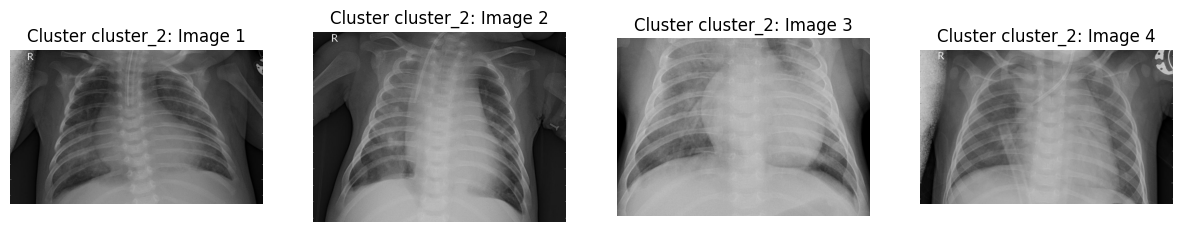

In [ ]:
# To display the images
def display_images(base_path, clusters, num_images_per_line=4):
    for cluster in clusters:
        cluster_path = os.path.join(base_path, cluster)
        image_files = os.listdir(cluster_path)

        # Displaying only the first few images to avoid overcrowding
        image_files = image_files[:num_images_per_line]

        fig, axs = plt.subplots(1, len(image_files), figsize=(15, 5))

        for i, img_file in enumerate(image_files):
            img_path = os.path.join(cluster_path, img_file)
            img = Image.open(img_path)
            axs[i].imshow(img,cmap="gray")
            axs[i].axis('off')
            axs[i].set_title(f"Cluster {cluster}: Image {i+1}")

        plt.show()

# Paths to the cluster directories
base_path = '/content/clustered_images'
clusters = ['cluster_0', 'cluster_1', 'cluster_2']

# Display the images
display_images(base_path, clusters)